Створити автокодувальник для датасету рукописних цифр за допомогою бібліотеки Keras (використовуємо тільки звичайні шари).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.decomposition import PCA
from keras import layers, models

Підготовка даних

In [2]:
# Завантажуємо дані MNIST
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()

# Нормалізуємо дані
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
input_shape = (28, 28, 1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Побудувати автокодувальник без шуму, графік функції втрат, результати розпізнавання.

In [3]:

def build_autoencoder(input_shape):
    # Кодер
    encoder_input = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    # Декодер
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    # Обрізаємо до 28x28
    x = layers.Cropping2D(((2, 2), (2, 2)))(x)

    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(encoder_input, decoded)
    return autoencoder

autoencoder = build_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

Навчання моделі

In [4]:
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(x_test, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - loss: 0.2364 - val_loss: 0.1066
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.1007 - val_loss: 0.0888
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0881 - val_loss: 0.0823
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0824 - val_loss: 0.0786
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0790 - val_loss: 0.0763
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0769 - val_loss: 0.0748
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0753 - val_loss: 0.0739
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0743 - val_loss: 0.0732
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0733 - val_loss: 0.0725
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0727 - val_loss: 0.0717
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0720 - val_loss: 0.0710
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━

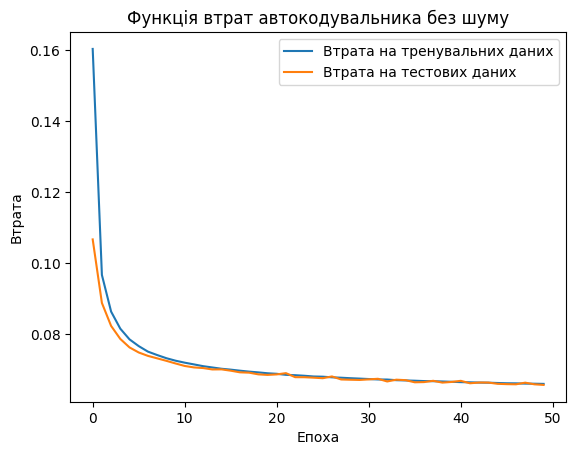

In [5]:
plt.plot(history.history['loss'], label='Втрата на тренувальних даних')
plt.plot(history.history['val_loss'], label='Втрата на тестових даних')
plt.title('Функція втрат автокодувальника без шуму')
plt.xlabel('Епоха')
plt.ylabel('Втрата')
plt.legend()
plt.show()

Візуалізація результатів

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


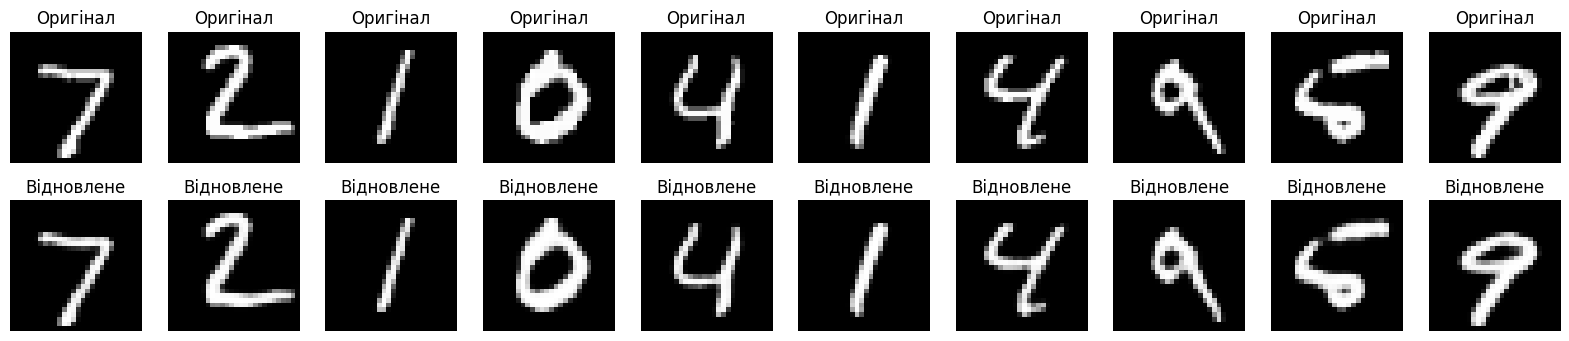

In [6]:
# Прогнозуємо на тестовому наборі
decoded_imgs = autoencoder.predict(x_test)

# Візуалізуємо оригінальні та відновлені зображення
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Оригінал")
    plt.axis('off')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Відновлене")
    plt.axis('off')
plt.show()

Побудувати автокодувальник із шумом, графік функції втрат, результати розпізнавання.

In [7]:
# Додаємо шум до зображень
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Навчання з шумом

In [9]:
noisy_autoencoder = build_autoencoder(input_shape)
noisy_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

history_noisy = noisy_autoencoder.fit(x_train_noisy, x_train,
                                      epochs=50,
                                      batch_size=256,
                                      shuffle=True,
                                      validation_data=(x_test_noisy, x_test))

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.2780 - val_loss: 0.1419
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.1351 - val_loss: 0.1182
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.1165 - val_loss: 0.1092
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1090 - val_loss: 0.1058
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1054 - val_loss: 0.1028
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.1031 - val_loss: 0.1018
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.1014 - val_loss: 0.0996
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.1001 - val_loss: 0.0989
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0990 - val_loss: 0.0978
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0979 - val_loss: 0.0974
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0972 - val_loss: 0.0973
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

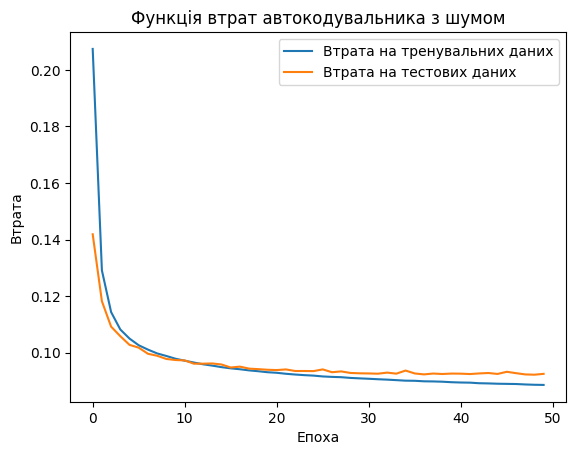

In [10]:
plt.plot(history_noisy.history['loss'], label='Втрата на тренувальних даних')
plt.plot(history_noisy.history['val_loss'], label='Втрата на тестових даних')
plt.title('Функція втрат автокодувальника з шумом')
plt.xlabel('Епоха')
plt.ylabel('Втрата')
plt.legend()
plt.show()

Візуалізація з шумом, оригінальні і відновлені

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


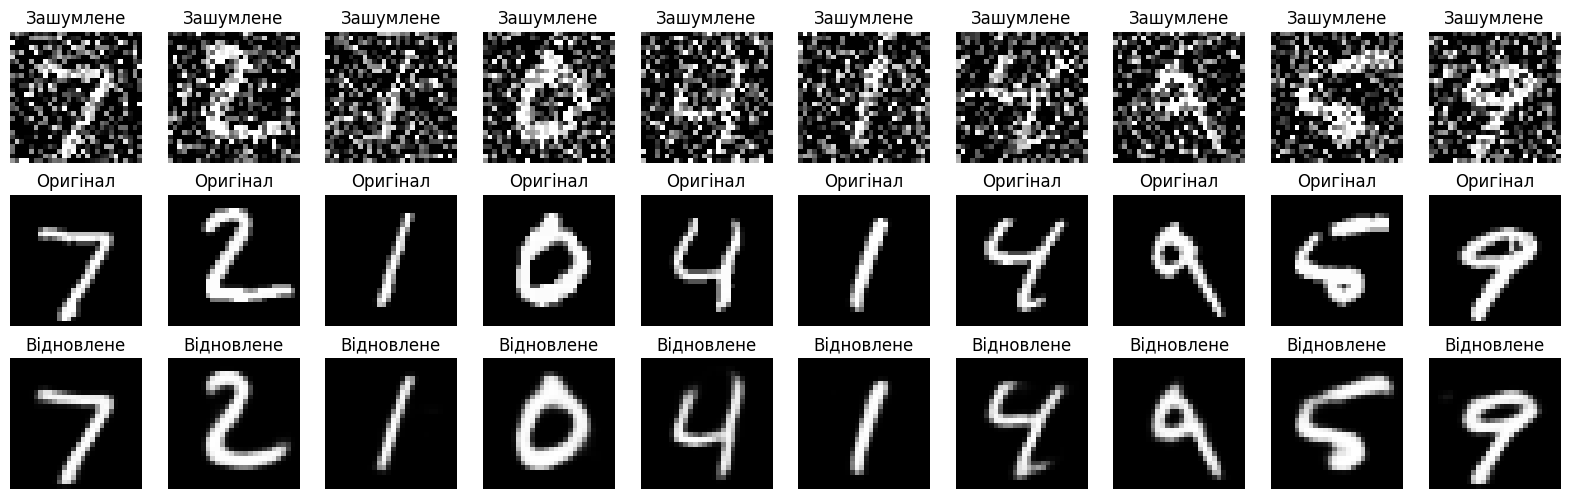

In [11]:
# Прогнозуємо на зашумлених тестових зображеннях
decoded_noisy_imgs = noisy_autoencoder.predict(x_test_noisy)

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Зашумлене")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Оригінал")
    plt.axis('off')

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_noisy_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Відновлене")
    plt.axis('off')
plt.show()

Розподіл векторів прихованого шару

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


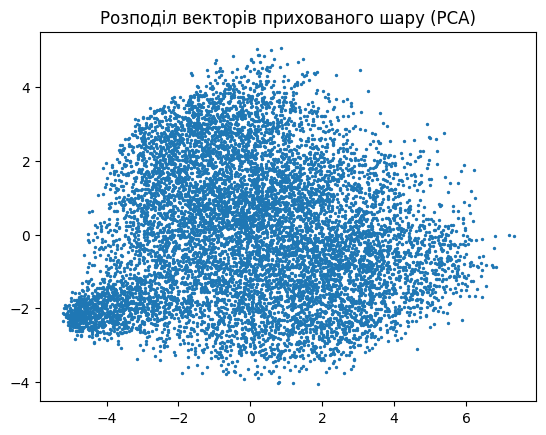

In [13]:
# Створюємо модель кодера і візуалізуємо
encoder = models.Model(inputs=noisy_autoencoder.input, outputs=noisy_autoencoder.layers[6].output)
encoded_imgs = encoder.predict(x_test)
encoded_imgs_flat = encoded_imgs.reshape((len(encoded_imgs), -1))
pca = PCA(2)
encoded_pca = pca.fit_transform(encoded_imgs_flat)
plt.scatter(encoded_pca[:, 0], encoded_pca[:, 1], s=2)
plt.title('Розподіл векторів прихованого шару (PCA)')
plt.show()

Висновок
Дана робота показала створення автокодувальника з шумом і без. За отриманими результатами реконструкції автоенкодера з шумом і без шуму, показує наскільки модель стійка до зашумлення даних. Показана висока ефективність моделі у відновленні зображень.


